# Зависимости

In [ ]:
%tensorflow_version 2.x
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (Embedding, Conv1D, MaxPooling1D,
                                     GlobalAveragePooling1D, Dropout,
                                     Dense, LSTM)

from tensorflow.keras import utils
import matplotlib.pyplot as plt
%matplotlib inline
from google.colab import files

from mycsv import split_file
from dataset import load_dataset
from transform import Converter

# Загрузка и конвертация данных

Разделение датасета на тренировочную выборку и тестовую.

In [ ]:
split_file('dataset.csv', split_ratio=0.8)

После разделения датасета в дериктории появиться два файла (тренировочный сет и тестовый).

* `maxlen` задает максимальную длину последовательности узлов функции (средняя длина последовательности ~50)

* `verbose` задает многословность функций обработчиков (то столько будет выводится информации во время обратоки); доступные значения от 0 до 3

In [ ]:
train_file_name = 'train_dataset.csv'
test_file_name = 'test_dataset.csv'
maxlen = 200
verbose = 3

Загрузка и трансформация данных для обучения.

In [ ]:
dataset = load_dataset(train_file_name, test_file_name, maxlen, verbose)
x_train, y_train, x_test, y_test, data_converter, marks_converter = dataset

load_data: Примеров в обучающей выбоке: 132588
load_data: Примеров в тестовой выбоке: 33075

load_data: Пример данных обучающей выборки:
arguments,args,self,timeout,defaults,none,body,TryExcept,body,Return,Call,AttributeLoad,AttributeLoad,self,attr,get,timeout,timeout,handlers,ExceptHandler,type,AttributeLoad,AttributeLoad,gevent,queue,empty,body,Raise,Call,NameLoad,timeout

load_data: Пример метки обучающей выборки:
call

load_data: Пример данных тестовой выборки:
arguments,args,self,defaults,body,If,Call,hasattr,self,Str,body,Assign,SubscriptStore,AttributeLoad,os,environ,Index,editor,AttributeLoad,self,attr,orelse,Delete,SubscriptDel,AttributeLoad,os,environ,Index,editor,Assign,AttributeStore,self,plugin,none,Assign,AttributeStore,self,env,none,Expr,Call,AttributeLoad,AttributeLoad,registration,attr,clear,Expr,Call,AttributeLoad,AttributeLoad,registration,attr,clear,Expr,Call,AttributeLoad,Call,super,NameLoad,self,teardown

load_data: Пример метки обучающей выборки:
teardown

load_d

Сериализация словарей конвертеров.

In [ ]:
data_converter.to_file()
marks_converter.to_file()

# Выбор модели нейронной сети

In [ ]:
# CNN-Model
model_name = 'fnp_cnn'
model = Sequential()
model.add(Embedding(len(data_converter), 32, input_length=maxlen))
model.add(Conv1D(100, 10, activation='relu', padding='same'))
model.add(Conv1D(100, 10, activation='relu', padding='same'))
model.add(MaxPooling1D(3))
model.add(Conv1D(160, 10, activation='relu', padding='same'))
model.add(Conv1D(160, 10, activation='relu', padding='same'))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.5))
model.add(Dense(len(marks_converter), activation='softmax'))

In [ ]:
# LSTM-Model
model_name = 'fnp_lstm'
model = Sequential()
model.add(Embedding(len(data_converter), 32, input_length=maxlen))
model.add(LSTM(128, return_sequences=True, dropout=0.2))
model.add(LSTM(128, dropout=0.2))
model.add(Dense(len(marks_converter), activation='softmax'))

In [ ]:
print('Название модели:', model_name)
model.summary()

Название модели: fnp_lstm
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 32)           316000    
_________________________________________________________________
lstm (LSTM)                  (None, 200, 128)          82432     
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 126)               16254     
Total params: 546,270
Trainable params: 546,270
Non-trainable params: 0
_________________________________________________________________


# Обучение нейронной сети

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
graph_history = {'accuracy': [], 'val_accuracy': []}

In [ ]:
history = model.fit( x_train, y_train,
                            validation_data = (x_test, y_test),
                            epochs=25,
                            batch_size=100,
                            shuffle=True,
                            verbose=1)
graph_history['accuracy'].extend(history.history['accuracy'])
graph_history['val_accuracy'].extend(history.history['val_accuracy'])

Epoch 1/25
1326/1326 [==============================] - 53s 40ms/step - loss: 3.3340 - accuracy: 0.2568 - val_loss: 2.7348 - val_accuracy: 0.3558
Epoch 2/25
1326/1326 [==============================] - 52s 39ms/step - loss: 2.4273 - accuracy: 0.4095 - val_loss: 2.2109 - val_accuracy: 0.4579
Epoch 3/25
1326/1326 [==============================] - 52s 39ms/step - loss: 2.0252 - accuracy: 0.4932 - val_loss: 1.9166 - val_accuracy: 0.5212
Epoch 4/25
1326/1326 [==============================] - 52s 39ms/step - loss: 1.7829 - accuracy: 0.5457 - val_loss: 1.7417 - val_accuracy: 0.5632
Epoch 5/25
1326/1326 [==============================] - 52s 39ms/step - loss: 1.5925 - accuracy: 0.5901 - val_loss: 1.6144 - val_accuracy: 0.5952
Epoch 6/25
1326/1326 [==============================] - 52s 39ms/step - loss: 1.4401 - accuracy: 0.6264 - val_loss: 1.5062 - val_accuracy: 0.6193
Epoch 7/25
1326/1326 [==============================] - 52s 39ms/step - loss: 1.3260 - accuracy: 0.6531 - val_loss: 1.4453 -

# Проверка качества обучения

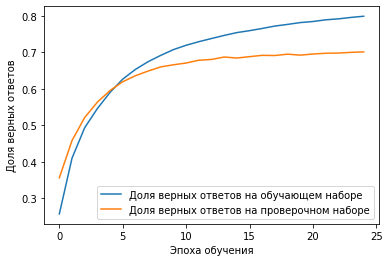

In [ ]:
plt.plot(graph_history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(graph_history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Доля верных ответов на тестовых данных составляет:',round(scores[1]* 100, 4),'%')

1034/1034 [==============================] - 10s 10ms/step - loss: 1.3214 - accuracy: 0.7013
Доля верных ответов на тестовых данных составляет: 70.1255 %


# Сохранить/загрузить модель нейронной сети

Сохранение нейронной сети на Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
model.save('gdrive/My Drive/models/function_name_prediction/{name}/maxlen{len}_e{epochs}_p{precent}.h5'.format(
    name=model_name,
    len=maxlen,
    epochs=len(graph_history['accuracy']),
    precent=int(graph_history['val_accuracy'][-1]*1000)
))

Сохранение нейронной сети в дирикторию.

In [ ]:
model.save('{name}_maxlen{len}_e{epochs}_p{precent}.h5'.format(
    name=model_name,
    len=maxlen,
    epochs=len(graph_history['accuracy']),
    precent=int(graph_history['val_accuracy'][-1]*1000)
))

Загрузка модели нейронной сети из файла.

In [ ]:
MODEL_PATH = ''
model = load_model(MODEL_PATH)